# PADS - Twitter

### Computação para Ciência de Dados

## Conteúdo
 [1. Introdução](#1.-Inrtrodução)
 
 [2. Coleta de dados](#2.-Coleta-de-dados)
 
 [3. Word Cloud](#3.-Word-Cloud)
 
 [4. Análise de sentimento](#4.-Análise-de-sentimento)
 
 [5. Indicadores](#5.-Indicadores)
 
 [6. Firebase](#6.-Firebase)
 
 [7. Conclusão](#7.-Conclusão)

## 1. Introdução

Neste trabalho, o objetivo é avaliar o conteúdo dos tweets ao longo da crise do coronavírus e sua eventual relação com o desempenho da bolsa de valores no mesmo período. Serão analisadas algumas contas de usuários do Twitter que falam sobre o mercado financeiro no dia-a-dia. Através da API do Twitter e outras bibliotecas para buscar e transformar as informações necessárias.

### Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pandasql
import pandas_datareader as pdr
import requests
import twitter
import wordcloud as wc
import datetime as dt
from firebase import firebase
import json
import nltk
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

/Users/vivi/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#!pip install python_jwt
#!pip install --upgrade gcloud
#!pip install sseclient
#!pip install requests-toolbelt
#!pip install nltk
#!pip install firebase-admin

#!python -m pip show python-firebase
#https://stackoverflow.com/questions/54691763/unable-to-connect-firebase-using-python-3-72

## 2. Coleta de dados

Foi construída uma base a partir de uma lista de contas do Twitter ligada ao mercado financeiro.

###  2.1. Download de dados do Twitter

##### Chaves de acesso ao API do Twitter
(As chaves foram omitidas por segurança, mas é possível obter uma criando uma [conta de desenvolvedor](https://developer.twitter.com/).)

In [1]:
api = twitter.Api(
        consumer_key='aa',
        consumer_secret='bb',
        access_token_key='cc',
        access_token_secret='dd')

NameError: name 'twitter' is not defined

A função a seguir busca e armazena os dados selecionados como ID, data e o próprio tweet em um dataframe

In [4]:
def AddtoDataFrame(t):

    df = pd.DataFrame()

    df['tweetID'] = [t.id for t in tweets]
    df['tweetText'] = [t.text for t in tweets]
    df['tweetRetweetCt'] = [t.retweet_count for t in tweets]
    df['tweetFavoriteCt'] = [t.favorite_count for t in tweets]
    df['tweetSource'] = [t.source for t in tweets]
    df['tweetCreated'] = [t.created_at for t in tweets]
    df['userID'] = [t.user.id for t in tweets]
    df['userScreen'] = [t.user.screen_name for t in tweets]
    df['userName'] = [t.user.name for t in tweets]
    df['tweetDate'] = pd.to_datetime(df['tweetCreated'])

    return df

- Coleta de dados do Twitter

Lista de usuários do Twitter vinculados ao mercado financeiro:

In [5]:
dados = pd.DataFrame()

In [6]:
users = ['BTGPDigital','xpinvestimentos','clear_corretora','PedroCerize','itaucorretora','rosa_riscala',
         'valoreconomico','alisc','MercadoBitcoin','jairbolsonaro','jdoriajr','MarpinPinheiro',
        'JamesGBrasil','cafecomferri','lnunesjr','RaphaFigueredo','VicenteMatheusZ']

In [7]:
for user in users:
    tweets = api.GetUserTimeline(screen_name= user , count="1000")
    dados = dados.append(AddtoDataFrame(tweets))

In [108]:
tweets_df = dados.copy() #df para salvar os dados posteriormente

In [9]:
#dados = tweets_df.copy() #caso seja necessário recarregar o dataframe sem ter que buscar os dados novamente no Twitter

### 2.2. Download da base salva no Firebase

Para evitar problemas de acesso no twitter, os dados são armazenados no firebase. A seguir, é feito o merge da base armazenada com o dataframe criado no item anterior.

In [10]:
def arruma_data(df, col_data, col_info):
     df[col_data] = pd.to_datetime(df[col_info])

In [11]:
fb = firebase.FirebaseApplication('https://insperpy.firebaseio.com/', None)

In [12]:
base = fb.get('/twitter', None) # Hashcode

In [13]:
for key in base.keys():
    print(key)
    temp = pd.read_json(base[key], orient = 'index')
    arruma_data(temp,'tweetDate','tweetCreated')
    #print(temp.head(2))
    dados = pd.concat([dados, temp], ignore_index = True)

1
2020-04-02
2020-04-12
2020-04-13


In [14]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13014 entries, 0 to 13013
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweetID          13014 non-null  int64              
 1   tweetText        13014 non-null  object             
 2   tweetRetweetCt   13014 non-null  int64              
 3   tweetFavoriteCt  13014 non-null  int64              
 4   tweetSource      13014 non-null  object             
 5   tweetCreated     13014 non-null  object             
 6   userID           13014 non-null  int64              
 7   userScreen       13014 non-null  object             
 8   userName         13014 non-null  object             
 9   tweetDate        13014 non-null  datetime64[ns, UTC]
 10  cloud_base       6240 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(4), object(6)
memory usage: 1.1+ MB


- Ajuste do formato da data

In [15]:
dados['tweetDate'] = dados['tweetDate'].dt.strftime('%Y-%m-%d') #remove horário do tweet

In [16]:
dados['tweetDate'] = pd.to_datetime(dados['tweetDate'])

In [18]:
dados['tweetDate']

0       2020-04-16
1       2020-04-16
2       2020-04-16
3       2020-04-16
4       2020-04-16
           ...    
13009   2020-01-10
13010   2020-01-10
13011   2020-01-10
13012   2020-01-10
13013   2020-01-10
Name: tweetDate, Length: 13014, dtype: datetime64[ns]

- Eliminação de eventuais tweets duplicados

In [19]:
len(dados['tweetID'].unique()) #quantidade de IDs únicos

5435

In [20]:
dados.head()

,tweetID,tweetText,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,tweetDate,cloud_base
0,1250806287740350472,"Hoje, às 18:30, o CEO do BTG Pactual, Roberto ...",2,22,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Thu Apr 16 15:20:32 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,NaN
1,1250800096083611648,"@nogueirah21 Olá, Helder! Tudo bem? Tentamos c...",0,0,"<a href=""http://twitter.com/download/android"" ...",Thu Apr 16 14:55:56 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,NaN
2,1250776807592386560,"Daqui a pouco, ao meio-dia, José Lúcio Nascime...",2,10,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Thu Apr 16 13:23:23 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,NaN
3,1250764506902470656,Pedidos de seguro-desemprego nos EUA atingiram...,10,48,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Thu Apr 16 12:34:31 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,NaN
4,1250747206996504577,Expectativa por retomada das atividades em paí...,4,47,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Thu Apr 16 11:25:46 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,NaN


In [21]:
dados.drop_duplicates('tweetID', keep = 'first', inplace = True)

## 3. Word Cloud

Criação um word cloud a partir dos dados armazenados e coletados no Twitter

In [23]:
dados['cloud_base'] = dados['tweetText'].str.split('https://t.co/', expand = True)[0]
dados['cloud_base'] = (dados['cloud_base'].str.replace('[.,:()"\n•!?-]','')).str.lower()
dados['cloud_base'] = dados['cloud_base'].str.lower()
dados['cloud_base'] = dados['cloud_base'].str.split(' ')

In [24]:
dados['cloud_base'] 

0        [hoje, às, 1830, o, ceo, do, btg, pactual, rob...
1        [@nogueirah21, olá, helder, tudo, bem, tentamo...
2        [daqui, a, pouco, ao, meiodia, josé, lúcio, na...
3        [pedidos, de, segurodesemprego, nos, eua, atin...
4        [expectativa, por, retomada, das, atividades, ...
                               ...                        
13009                               [@cafecomferri, virou]
13010                            [trump, betinou, no, dow]
13011                        [@otourodeouro, vai, ursinho]
13012    [srm, exodus, plus, fim, está, disponível, nas...
13013        [@lmn128, calma, que, tudo, vai, dar, errado]
Name: cloud_base, Length: 5435, dtype: object

In [25]:
dados['userScreen'].unique()

array(['BTGPDigital', 'xpinvestimentos', 'clear_corretora', 'PedroCerize',
       'itaucorretora', 'rosa_riscala', 'valoreconomico', 'alisc',
       'MercadoBitcoin', 'jairbolsonaro', 'jdoriajr', 'MarpinPinheiro',
       'JamesGBrasil', 'cafecomferri', 'lnunesjr', 'RaphaFigueredo',
       'VicenteMatheusZ'], dtype=object)

In [26]:
cloud = dados['cloud_base'] #[dados['userScreen'] == 'jdoriajr']

In [31]:
nltk.download('stopwords') #biblioteca com stopwrods em várias línguas

[nltk_data] Downloading package stopwords to /Users/vivi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [33]:
#sem_stop = cloud[~cloud.isin(stopwords)]

In [34]:
cloud

0        [hoje, às, 1830, o, ceo, do, btg, pactual, rob...
1        [@nogueirah21, olá, helder, tudo, bem, tentamo...
2        [daqui, a, pouco, ao, meiodia, josé, lúcio, na...
3        [pedidos, de, segurodesemprego, nos, eua, atin...
4        [expectativa, por, retomada, das, atividades, ...
                               ...                        
13009                               [@cafecomferri, virou]
13010                            [trump, betinou, no, dow]
13011                        [@otourodeouro, vai, ursinho]
13012    [srm, exodus, plus, fim, está, disponível, nas...
13013        [@lmn128, calma, que, tudo, vai, dar, errado]
Name: cloud_base, Length: 5435, dtype: object

- Stopwords adicionais

In [40]:
parada = ['rt', 'de','para','em','que','da','mas','na','nos','no','por','pelo','ao','rt','-','e','os','as','um','como','uma','já','oi','até','ele','ela','você','com','tem','aos','esse','essa','este','esta'
          'isso','isto','se','vai','ou','dos','das','sobre','está','também','muito','ainda','olá','às','nosso','estão','entre','foi','este',',','?','!',':',';','•','RT','@','-','*','$','(',')','%','\n',
         'te','pode','o','a','deve',' isso','sua','seu','nossa','mai','será','pra','vc',' olá','ola','r$','@*','não','bdm','dia','hoje','diz','semana','isso', 'pela','aqui','ser','dm', 'q', 'to', 'the', 'in']

In [41]:
for p in parada:
    if p not in stopwords:
        stopwords.append(p)

In [42]:
len(stopwords)

248

In [43]:
output  = []

for l in cloud:
    for p in l:
        if not p in parada:
            output.append(p)

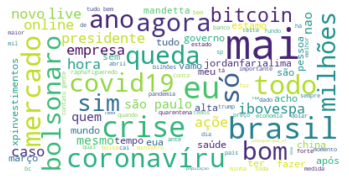

In [44]:
wordcloud = wc.WordCloud(max_font_size=50, 
                         max_words=100, 
                         background_color="white").generate(" ".join(output))

#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## 4. Análise de sentimento

Em seguida, será feita uma análise simples de sentimento durante a crise do coronavírus no mercado financeiro. Os seguintes passos serão realizados:

- Escolhas de palavras-chave ligadas à atual pandemia de coronavírus
- Verificação da ocorrência dessas palavras-chaves ao longo do tempo
- Cruzamento dessas ocorrências com o desempenho da bolsa de valores

In [45]:
# listas de palavras-chaves

word = ['coronavirus', 'coronavírus', 'corona*', 'corona', 'virus', 'vírus', 'covid*', 'infectad*', 'doen*', 'mort*', 'minist* da saude','quarentena','pandemia','epidemia', 'casos']

In [46]:
dados['lowerText'] = dados['tweetText'].str.lower()

In [47]:
dados_filtro = dados[dados['lowerText'].str.contains('|'.join(word))]

In [48]:
dados_filtro.head()

,tweetID,tweetText,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,tweetDate,cloud_base,lowerText
2,1250776807592386560,"Daqui a pouco, ao meio-dia, José Lúcio Nascime...",2,10,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Thu Apr 16 13:23:23 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[daqui, a, pouco, ao, meiodia, josé, lúcio, na...","daqui a pouco, ao meio-dia, josé lúcio nascime..."
4,1250747206996504577,Expectativa por retomada das atividades em paí...,4,47,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Thu Apr 16 11:25:46 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[expectativa, por, retomada, das, atividades, ...",expectativa por retomada das atividades em paí...
12,1250386997635682304,Enquanto o número dos casos do Covid-19 no mun...,5,30,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Wed Apr 15 11:34:25 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-15,"[enquanto, o, número, dos, casos, do, covid19,...",enquanto o número dos casos do covid-19 no mun...
13,1250230820616495107,"Amanhã, no Morning Call, Jerson Zanlorenzi rec...",3,22,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Wed Apr 15 01:13:50 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-15,"[amanhã, no, morning, call, jerson, zanlorenzi...","amanhã, no morning call, jerson zanlorenzi rec..."
21,1249795266783465480,Apesar da manutenção das tensões relacionadas ...,5,45,"<a href=""http://twitter.com/download/iphone"" r...",Mon Apr 13 20:23:06 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-13,"[apesar, da, manutenção, das, tensões, relacio...",apesar da manutenção das tensões relacionadas ...


In [49]:
len(dados_filtro)

787

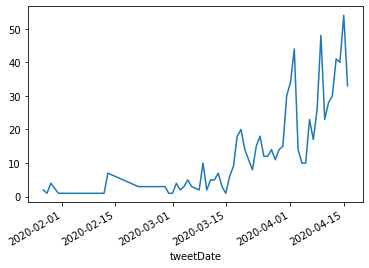

In [50]:
graph = dados_filtro.groupby('tweetDate').count()['tweetID']
graph.plot()

O gráfico mostra o aumento da quantidade de tweets contendo as palavras selecionadas ao longo do tempo. Fica evidente o aumento a partir de março.

- Dados do Ibovespa

Para baixar os dados do Ibovespa, utilza-se a biblioteca [Pandas datareader](https://pandas-datareader.readthedocs.io/en/latest/), que puxa os dados de mercado diretamente do [Yahoo! Finance](https://finance.yahoo.com).
As datas de início e fim da amostra são determinadas pela base dos tweets.

In [51]:
start_date = dados_filtro ['tweetDate'].min().date()
end_date = dados_filtro ['tweetDate'].max().date()

In [52]:
start_date

datetime.date(2020, 1, 27)

In [53]:
end_date

datetime.date(2020, 4, 16)

In [54]:
ibov = pdr.get_data_yahoo('^BVSP', start_date, end_date) #buscando dados do índice

In [55]:
ibov['var'] = ibov['Close'].pct_change()[1:]
ibov ['net'] = (ibov['var']) > 0

In [56]:
ibov = ibov.join(dados_filtro.groupby('tweetDate').count()['tweetID'])

In [57]:
ibov.rename(columns={"tweetID": "tweets"}, inplace = True)

In [58]:
ibov.fillna(0, inplace = True)

- Ibovespa vs quantidade de palavras-chaves ao longo do tempo

In [84]:
weeks = mdates.WeekdayLocator()
weeks_fmt = mdates.DateFormatter('%b %d')

Text(0.5, 1.0, 'Ibovespa vs Key Tweets ')

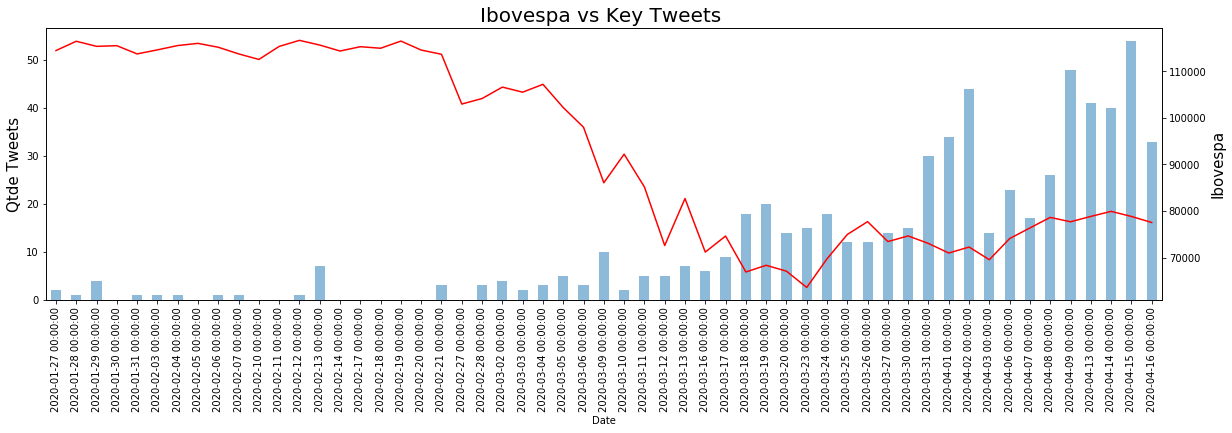

In [64]:
fig = plt.figure(figsize = (20,5))
ax = ibov['tweets'].plot(kind="bar", alpha = 0.5)
ax.set_ylabel('Qtde Tweets', fontsize = 15)

ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),ibov['Adj Close'], color = 'r')
ax2.set_ylabel('Ibovespa',fontsize = 15)

plt.title('Ibovespa vs Key Tweets ', fontsize = 20)

Acima, é comparado o desempenho do Ibovespa com a quantidade de tweets das palavras selecionadas.
A seguir, será avaliado se essas palavras possuem um tom positivo ou negativo para o mercado. Os seguintes itens serão executados:

- Escolha de palavras com conotação positiva e negativa
- Cruzamento das palavras com a base de dados coletada do Twitter
- Gráfico com a incidência dessas palavras e o desempenho do Ibovespa no tempo

In [65]:
palavra_positiva = ['sobe','subiu','ganh*', 'alt*']

In [66]:
palavra_negativa = ['cai*','perd*','pior*','baix*']

In [67]:
dados_filtro_neg = dados[dados['lowerText'].str.contains('|'.join(palavra_negativa))]
graph_neg = dados_filtro_neg.groupby('tweetDate').count()['tweetID']

In [68]:
dados_filtro_pos = dados[dados['lowerText'].str.contains('|'.join(palavra_positiva))]
graph_pos = dados_filtro_pos.groupby('tweetDate').count()['tweetID']

In [69]:
sentimento = pd.DataFrame()
sentimento ['positivo'] = graph_pos
sentimento ['negativo'] = graph_neg
sentimento ['negativo'] = sentimento ['negativo'].replace(np.nan, 0)
sentimento ['net'] = sentimento ['positivo'] - sentimento ['negativo']
sentimento ['color'] = (sentimento ['positivo'] - sentimento ['negativo']) >0

Na base, é criada uma coluna com um "net" das palavras, para contabilizar se houveram mais palavras positivas ou negativas. Dessa forma, seleciona-se a cor correspondente ao sentimento.

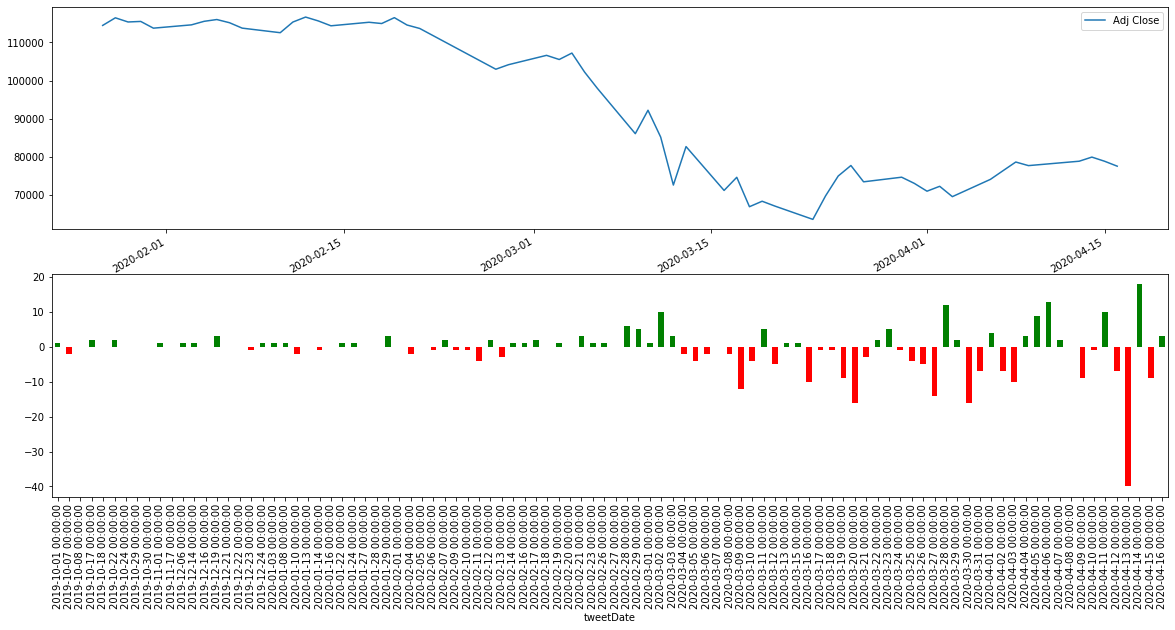

In [71]:
fig, ax = plt.subplots(2, figsize=(20,10))
ibov.plot(y=["Adj Close"], ax=ax[0])
sentimento['net'].plot.bar(ax=ax[1], color=sentimento.color.map({True: 'g', False: 'r'}))

plt.show()

Além do aumento de tweets contendo essas palavras, observa-se uma relação entre a performance do índice e o sentimento geral do dia.

## 5. Indicadores

A seguir, será avaliada a quantidade de tweets ao longo do tempo, em diferentes janelas.

#### Mensagens por dia

In [109]:
dados.head()

,tweetID,tweetText,tweetRetweetCt,tweetFavoriteCt,tweetSource,tweetCreated,userID,userScreen,userName,tweetDate,cloud_base,lowerText
0,1250806287740350472,"Hoje, às 18:30, o CEO do BTG Pactual, Roberto ...",2,22,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Thu Apr 16 15:20:32 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[hoje, às, 1830, o, ceo, do, btg, pactual, rob...","hoje, às 18:30, o ceo do btg pactual, roberto ..."
1,1250800096083611648,"@nogueirah21 Olá, Helder! Tudo bem? Tentamos c...",0,0,"<a href=""http://twitter.com/download/android"" ...",Thu Apr 16 14:55:56 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[@nogueirah21, olá, helder, tudo, bem, tentamo...","@nogueirah21 olá, helder! tudo bem? tentamos c..."
2,1250776807592386560,"Daqui a pouco, ao meio-dia, José Lúcio Nascime...",2,10,"<a href=""https://ads-api.twitter.com"" rel=""nof...",Thu Apr 16 13:23:23 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[daqui, a, pouco, ao, meiodia, josé, lúcio, na...","daqui a pouco, ao meio-dia, josé lúcio nascime..."
3,1250764506902470656,Pedidos de seguro-desemprego nos EUA atingiram...,10,48,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Thu Apr 16 12:34:31 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[pedidos, de, segurodesemprego, nos, eua, atin...",pedidos de seguro-desemprego nos eua atingiram...
4,1250747206996504577,Expectativa por retomada das atividades em paí...,4,47,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Thu Apr 16 11:25:46 +0000 2020,818805955609657344,BTGPDigital,BTG Pactual digital,2020-04-16,"[expectativa, por, retomada, das, atividades, ...",expectativa por retomada das atividades em paí...


In [110]:
dados['day'] = pd.to_datetime(dados['tweetDate']).dt.to_period('D')

In [111]:
daily_tweets = pd.crosstab(index = dados['day'], columns = dados['userScreen'])

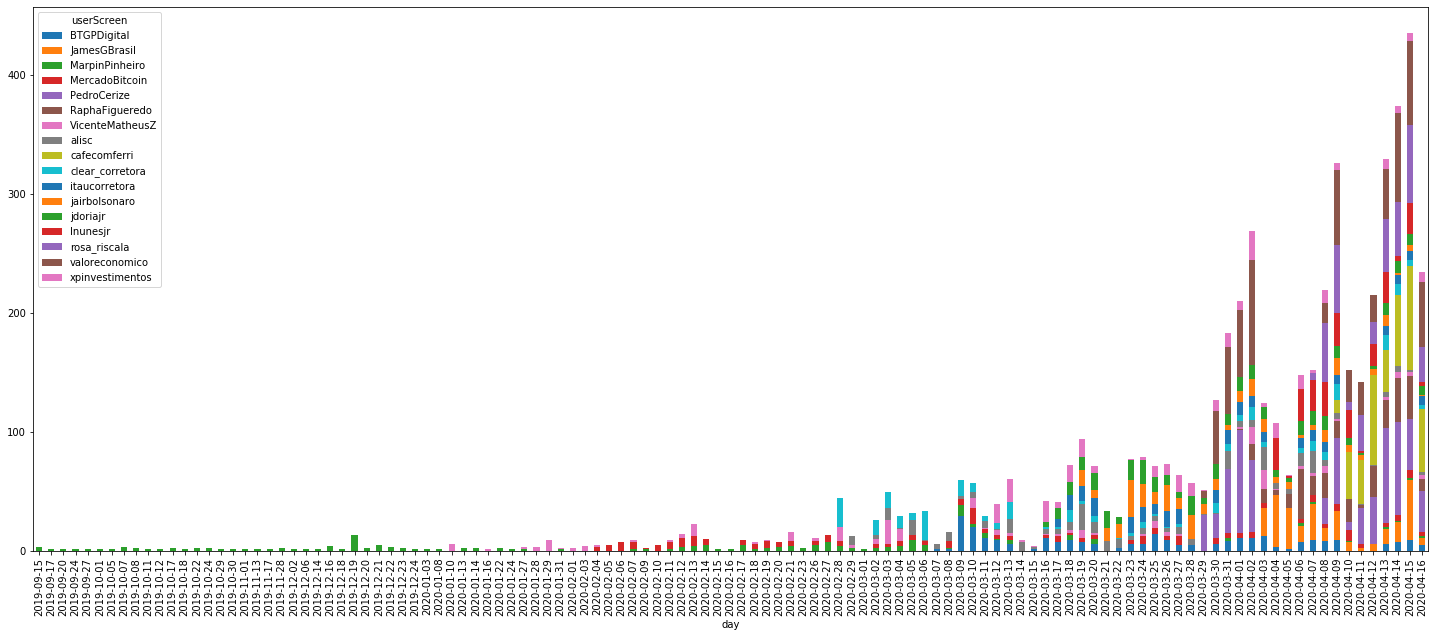

In [112]:
daily_tweets.plot(kind = 'bar', stacked = True, figsize = (25,10))

In [226]:
graph_tweet_perday = dados['tweetDate'].value_counts()


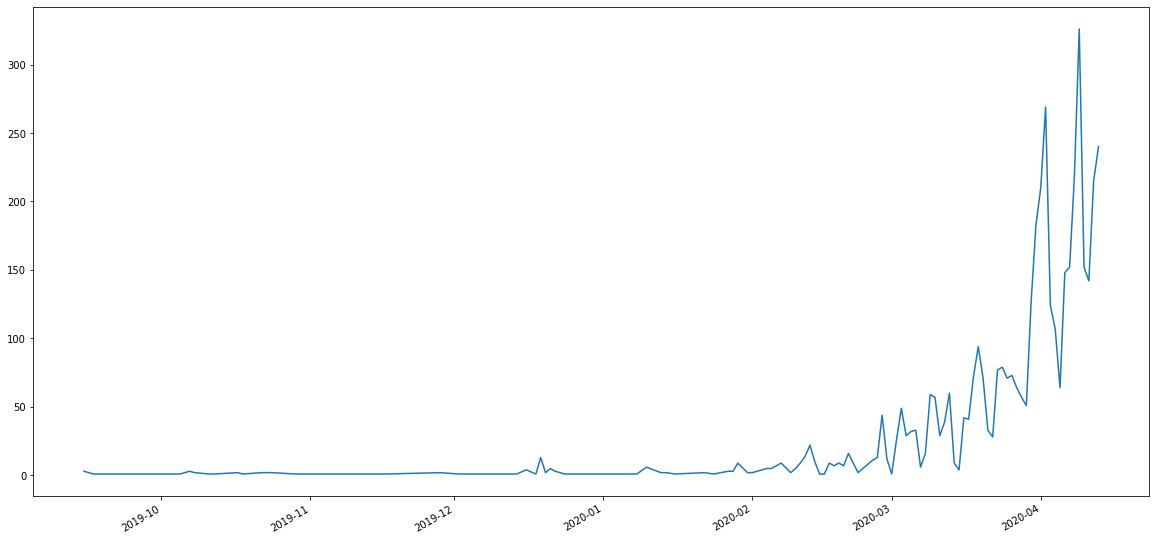

In [230]:
graph_tweet_perday.plot(figsize = (20,10))

#### Mensagens por hora

In [113]:
dados['hora'] = pd.to_datetime(dados['tweetCreated'])
dados['hora']

0       2020-04-16 15:20:32+00:00
1       2020-04-16 14:55:56+00:00
2       2020-04-16 13:23:23+00:00
3       2020-04-16 12:34:31+00:00
4       2020-04-16 11:25:46+00:00
                   ...           
13009   2020-01-10 19:14:52+00:00
13010   2020-01-10 17:03:02+00:00
13011   2020-01-10 16:32:44+00:00
13012   2020-01-10 16:09:50+00:00
13013   2020-01-10 16:00:15+00:00
Name: hora, Length: 5435, dtype: datetime64[ns, UTC]

In [114]:
result = dados.groupby([pd.Grouper(key='hora', freq='5h')]).count()

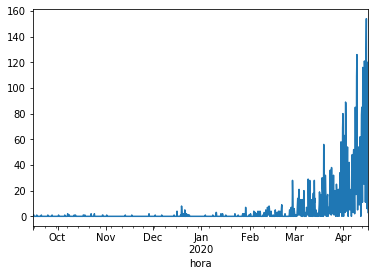

In [115]:
result ['tweetID'].plot()

#### Mensagens por semana

In [116]:
result = dados.groupby([pd.Grouper(key='hora', freq='1w')]).count()

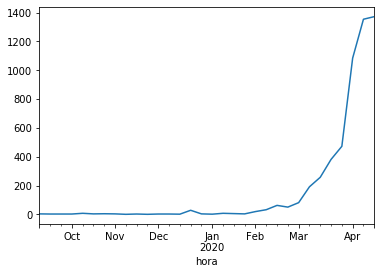

In [117]:
result ['tweetID'].plot()

## 6. Firebase

Por fim, os dados são armazenados no Firebase

In [118]:
fb = firebase.FirebaseApplication('https://seuendereco.firebaseio.com/', None)

In [107]:
hoje = dt.datetime.today().date()
df_json = tweets_df.reset_index(drop = True).to_json(orient = 'index')
fb.put('/twitter', name = str(hoje), data = df_json)

'{"0":{"tweetID":1250806287740350472,"tweetText":"Hoje, \\u00e0s 18:30, o CEO do BTG Pactual, Roberto Sallouti, entrevista ao vivo e com tradu\\u00e7\\u00e3o simult\\u00e2nea o fundador da\\u2026 https:\\/\\/t.co\\/NwKUE5byvU","tweetRetweetCt":2,"tweetFavoriteCt":22,"tweetSource":"<a href=\\"https:\\/\\/ads-api.twitter.com\\" rel=\\"nofollow\\">Twitter for Advertisers<\\/a>","tweetCreated":"Thu Apr 16 15:20:32 +0000 2020","userID":818805955609657344,"userScreen":"BTGPDigital","userName":"BTG Pactual digital","tweetDate":1587050432000},"1":{"tweetID":1250800096083611648,"tweetText":"@nogueirah21 Ol\\u00e1, Helder! Tudo bem? Tentamos contato por telefone hoje sem sucesso e encaminhamos um e-mail novamen\\u2026 https:\\/\\/t.co\\/KT4LmxUBvP","tweetRetweetCt":0,"tweetFavoriteCt":0,"tweetSource":"<a href=\\"http:\\/\\/twitter.com\\/download\\/android\\" rel=\\"nofollow\\">Twitter for Android<\\/a>","tweetCreated":"Thu Apr 16 14:55:56 +0000 2020","userID":818805955609657344,"userScreen":"BTG

## 7. Conclusão

O trabalho avaliou uma base de tweets postados por integrantes do mercado financeiro ao longo da crise do coronavírus e como essas mensagens se relacionaram com o desempenho do mercado. Além disso, foram gerados alguns gráficos com a quantidade de tweets em diferentes janelas de tempo.

Pode-se se desenvolver as seguintes frentes no futuro:

- Ampliar a análise de sentimento usando ferramentas e pacotes próprios para isso
- Usar contas estrangeiras, cujo uso do twitter no mercado financeiro é ainda mais disseminado que no Brasil
- Avaliar o desempenho 'intraday' do Ibovespa e comparar com o horário dos tweets